In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Conv2D, MaxPool2D
from keras.utils import np_utils, plot_model
from PIL import Image
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Let's Load in the Data

In [2]:
# Using a .py in the utils folder
sys.path.append('./utils/')
import mnist_reader

In [3]:
# Data sourced from: https://www.kaggle.com/zalando-research/fashionmnist
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [4]:
# Let's create a dict to map encoded target to their class in English
mapping = {0: "T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 
           5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}

## Let's take a look at some of the images

In [5]:
X_train_indices = np.random.randint(0,X_train.shape[0], size = 5*5)

In [6]:
def show_fashion_mnist(plot_rows, plot_columns, cmap=None, random_seed=False):
    '''Generates a plot_rows * plot_columns grid of randomly selected images from FashionMnist's X_train.
    Meant for EDA. 
    '''
    # Grabs plot_rows*plot_columns indices at random from X_train. 
    if random_seed:
        np.random.seed(42)
        
    X_train_indices = np.random.randint(0,X_train.shape[0], size = plot_rows*plot_columns)
    
    # Creates our plots
    fig, ax = plt.subplots(plot_rows, plot_columns, figsize=(18,18))
    
    reshaped_images_list = []

    for X_train_index in X_train_indices:
        # Reshapes our images, appends tuple with reshaped image and class to a reshaped_images_list.
        reshaped_image = X_train[X_train_index].reshape((28,28))
        image_class = mapping[y_train[X_train_index]]
        reshaped_images_list.append((reshaped_image, image_class))
    
    # Plots each image in reshaped_images_list to its own subplot
    counter = 0
    for row in range(plot_rows):
        for col in range(plot_columns):
            ax[row, col].imshow(reshaped_images_list[counter][0], cmap=cmap)
            ax[row, col].set_title(reshaped_images_list[counter][1])
            counter +=1

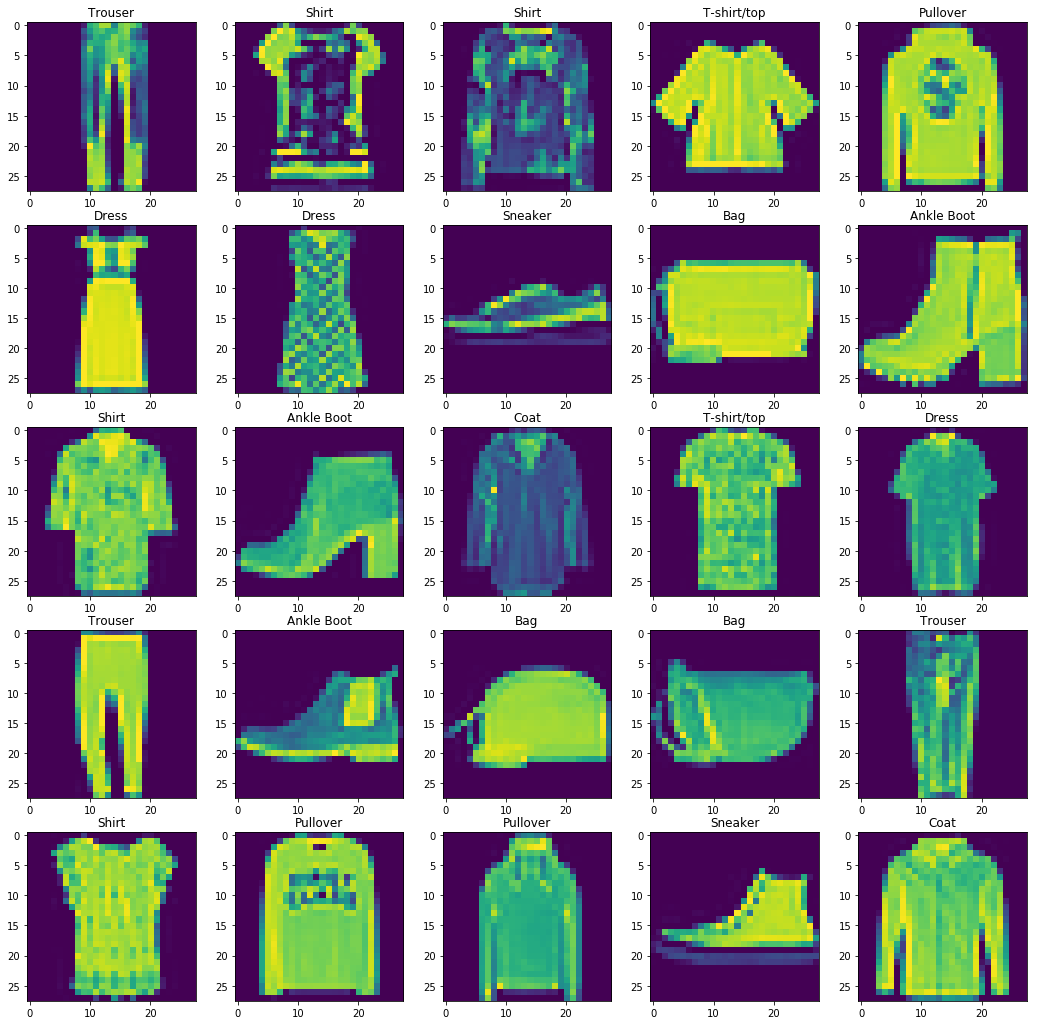

In [7]:
# The t shirts and dresses look pretty similar in some instances. 
# Certain high top sneakers look similar to boots and sandals at this resolution, too. 
# Some of these sandals have very high heels, too.
show_fashion_mnist(5,5, random_seed=True)

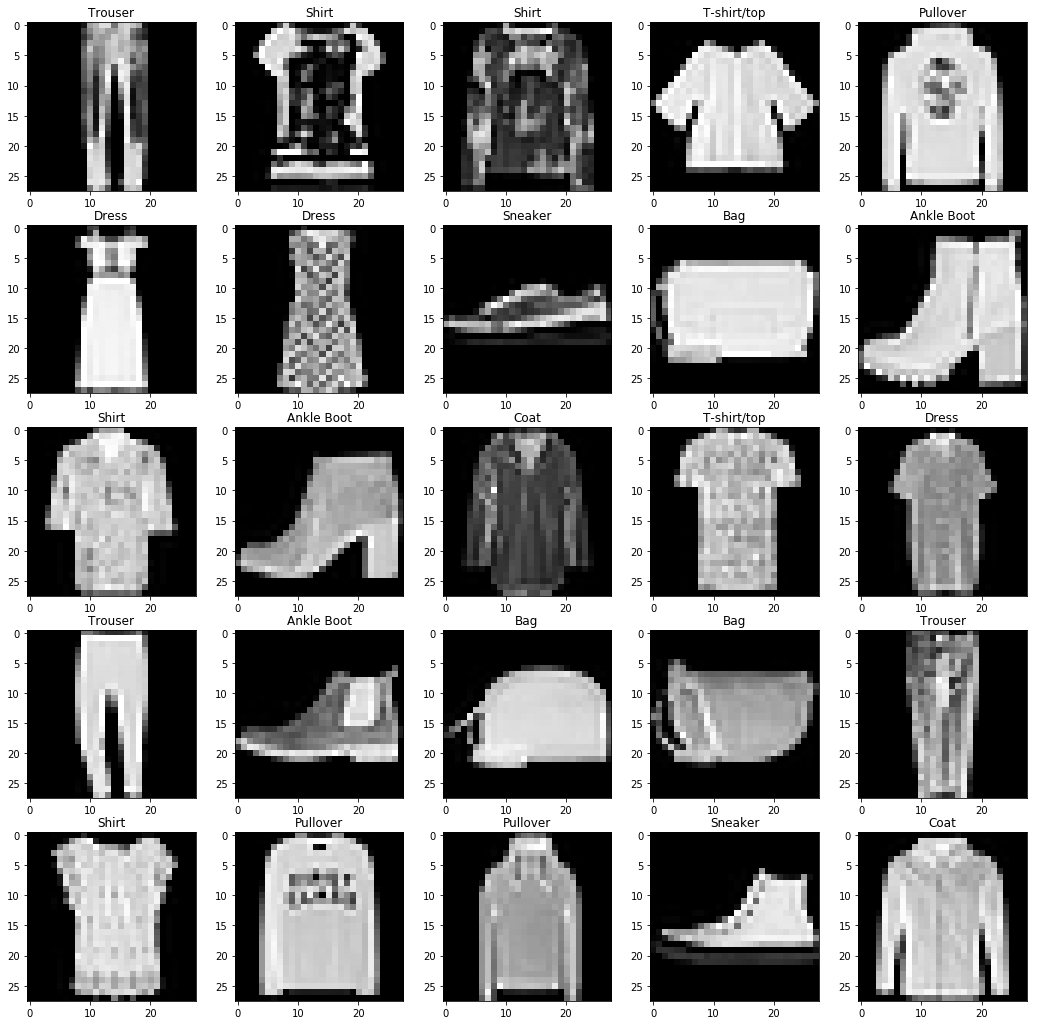

In [8]:
# These are only 1 channel images - black and white. Color representations above were a little weird.
# Let's see them in black and white.
show_fashion_mnist(5,5, cmap=plt.cm.gray, random_seed=True)

## What does the distribution of target labels look like?

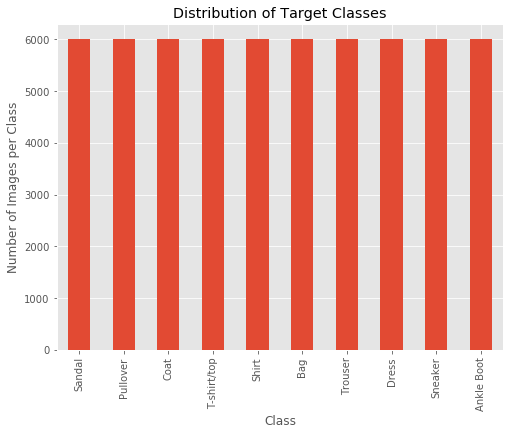

In [9]:
# Equally balanced
plt.style.use('ggplot')
plt.title("Distribution of Target Classes")
plt.ylabel("Number of Images per Class")
plt.xlabel("Class")
pd.Series([mapping[x] for x in y_train]).value_counts().plot(kind='bar', figsize=(8,6));

## Preprocessing

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [11]:
X_train.max()

1.0

In [12]:
X_train.min()

0.0

In [13]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# A simple deep net architecture 

In [14]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(784,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

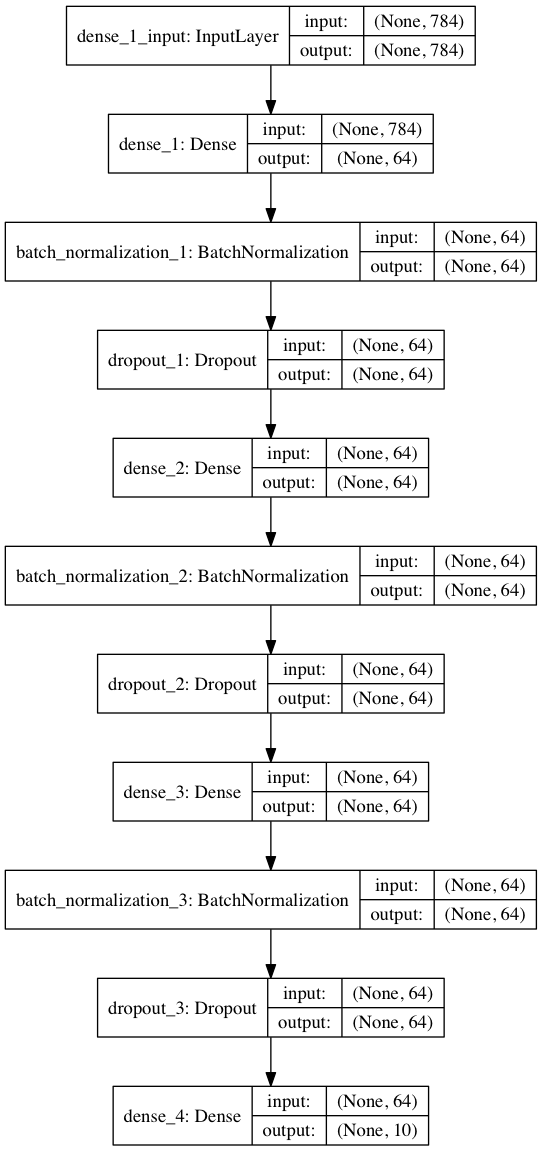

In [15]:
plot_model(model, to_file='model1.png', show_shapes=True)
Image.open('model1.png')

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
my_fit_model = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s - loss: 0.7094 - acc: 0.7555 - val_loss: 0.4567 - val_acc: 0.8357
Epoch 2/50
60000/60000 [==============================] - 5s - loss: 0.4839 - acc: 0.8307 - val_loss: 0.4185 - val_acc: 0.8507
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 0.4363 - acc: 0.8445 - val_loss: 0.4097 - val_acc: 0.8556
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 0.4128 - acc: 0.8522 - val_loss: 0.4036 - val_acc: 0.8536
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 0.4008 - acc: 0.8564 - val_loss: 0.3752 - val_acc: 0.8667
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 0.3863 - acc: 0.8613 - val_loss: 0.3686 - val_acc: 0.8680
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 0.3777 - acc: 0.8657 - val_loss: 0.3819 - val_acc: 0.8629
Epoch 8/50
60000/60000 [==============================] - 4s 

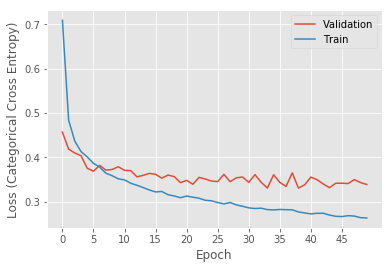

In [20]:
# Why is my train loss higher than my validation loss every time?
plt.plot(my_fit_model.history['val_loss'], label="Validation")
plt.plot(my_fit_model.history['loss'], label = "Train")
plt.xlabel("Epoch")
plt.ylabel("Loss (Categorical Cross Entropy)")
plt.xticks(np.arange(0, len(my_fit_model.history['val_loss']), 5.0))
plt.legend();

# Let's try with a convolutional neural network

In [17]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [18]:
model = Sequential()
model.add(Conv2D(filters = 15, kernel_size=(5,5), input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 30, kernel_size=(4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 45, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

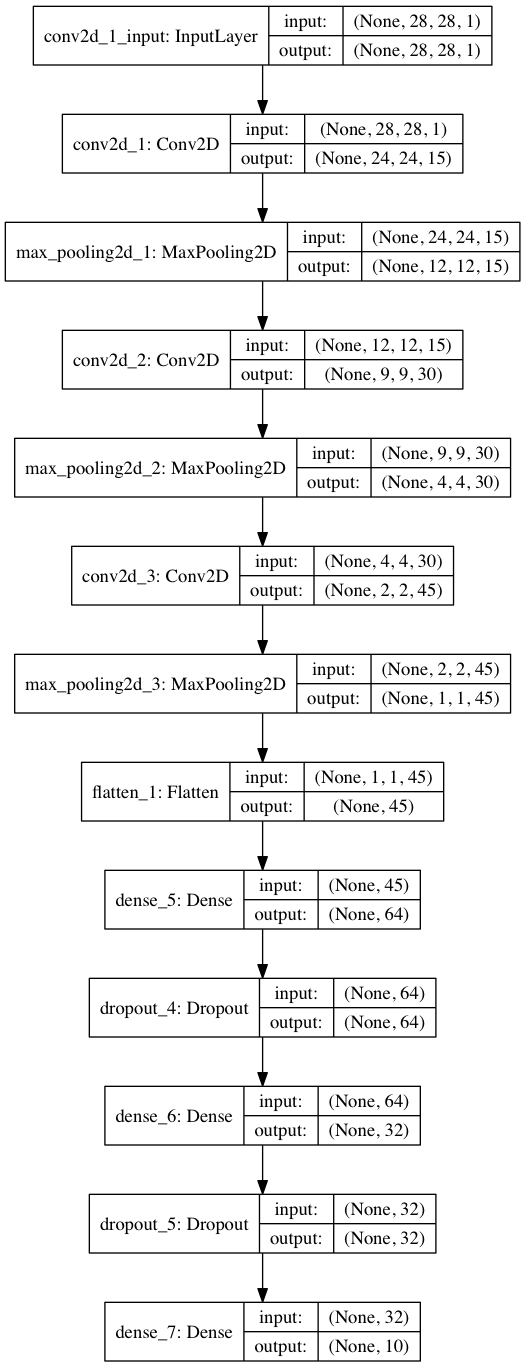

In [19]:
plot_model(model, to_file='Conv_model1.png', show_shapes=True)
Image.open('Conv_model1.png')

In [ ]:
my_fit_model = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 51s - loss: 0.7943 - acc: 0.7093 - val_loss: 0.5189 - val_acc: 0.7998
Epoch 2/10
60000/60000 [==============================] - 45s - loss: 0.5214 - acc: 0.8107 - val_loss: 0.4310 - val_acc: 0.8417
Epoch 3/10
60000/60000 [==============================] - 41s - loss: 0.4474 - acc: 0.8437 - val_loss: 0.3903 - val_acc: 0.8586
Epoch 4/10
60000/60000 [==============================] - 45s - loss: 0.4000 - acc: 0.8601 - val_loss: 0.3590 - val_acc: 0.8722
Epoch 5/10
60000/60000 [==============================] - 45s - loss: 0.3758 - acc: 0.8685 - val_loss: 0.3647 - val_acc: 0.8670
Epoch 6/10
60000/60000 [==============================] - 47s - loss: 0.3525 - acc: 0.8773 - val_loss: 0.3388 - val_acc: 0.8788
Epoch 7/10
60000/60000 [==============================] - 49s - loss: 0.3332 - acc: 0.8821 - val_loss: 0.3262 - val_acc: 0.8834
Epoch 8/10
60000/60000 [==============================

In [ ]:
plt.plot(my_fit_model.history['val_loss'], label="Validation")
plt.plot(my_fit_model.history['loss'], label = "Train")
plt.xlabel("Epoch")
plt.ylabel("Loss (Categorical Cross Entropy)")
plt.xticks(np.arange(0, len(my_fit_model.history['val_loss']), 5.0))
plt.legend();